В этом задании вам нужно воспользоваться опытом предыдущих недель, чтобы побить бейзлайн в соревновании по сентимент-анализу отзывов на товары на Kaggle Inclass:

https://www.kaggle.com/c/simplesentiment

In [74]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import warnings
from nltk.corpus import movie_reviews
warnings.filterwarnings('ignore')
%matplotlib inline

In [75]:
def create_pipeline(vectorizer, classifier):
    return Pipeline(
        [("vectorizer", vectorizer),
         ("classifier", classifier)]
        )

def get_X_y():
    X = []
    for field in ("neg", "pos"):
        tmp = movie_reviews.fileids(field)
        X.extend([" ". join(movie_reviews.words(fileids=[f])) for f in tmp])
    y = [0] * 1000 + [1] * 1000
    return X, y

In [6]:
# считываем данные

data = pd.read_csv("../data/products_sentiment_train.tsv", sep='\t', header=None)
data.head() 

,0,1
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


Смотрим на распределение классов и наличие пропущенных значений.

In [18]:
data[1].value_counts()

1    1274
0     726
Name: 1, dtype: int64

In [19]:
data.shape

(2000, 2)

Будем делать кросс валидацию (cv = 5) с итоговой проверкой на тестовой выборке. 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.25)

В качестве классификатора и векторайзера будем использовать то что рассмотрели в прошлых неделях:
- LogisticRegression
- LinearSVC  

и
- CountVectorizer
- TfidfVectorizer

Так как нет явно преобладающего класса в выборках, и нам одинаково важно корректно оценивать как положительные так и отрицательные отзывы, в качестве метрики будем использовать accuracy

Для начала рассмотрим решения из коробки

In [66]:
columns = ["cv_score", "train_score", "test_score"]
result = []
names = []

for vec in (CountVectorizer, TfidfVectorizer):
    for clf in (LogisticRegression, LinearSVC):
        
        names.append(vec.__name__  + " " +  clf.__name__)
        pipeline = create_pipeline(vec(), clf())
        
        # scoring="ROC-AUC"
        cv_score = cross_val_score(pipeline, X_train, y_train, cv=5).mean() 
        pipeline.fit(X_train, y_train)
        train_score = accuracy_score(y_train, pipeline.predict(X_train))
        test_score = accuracy_score(y_test, pipeline.predict(X_test))
        
        result.append([cv_score, train_score, test_score])

In [71]:
scores = pd.DataFrame(result, columns=columns, index=names)
scores

,cv_score,train_score,test_score
CountVectorizer LogisticRegression,0.759976,0.984667,0.760
CountVectorizer LinearSVC,0.754629,1.000000,0.764
TfidfVectorizer LogisticRegression,0.755318,0.886667,0.764
TfidfVectorizer LinearSVC,0.766629,0.997333,0.778


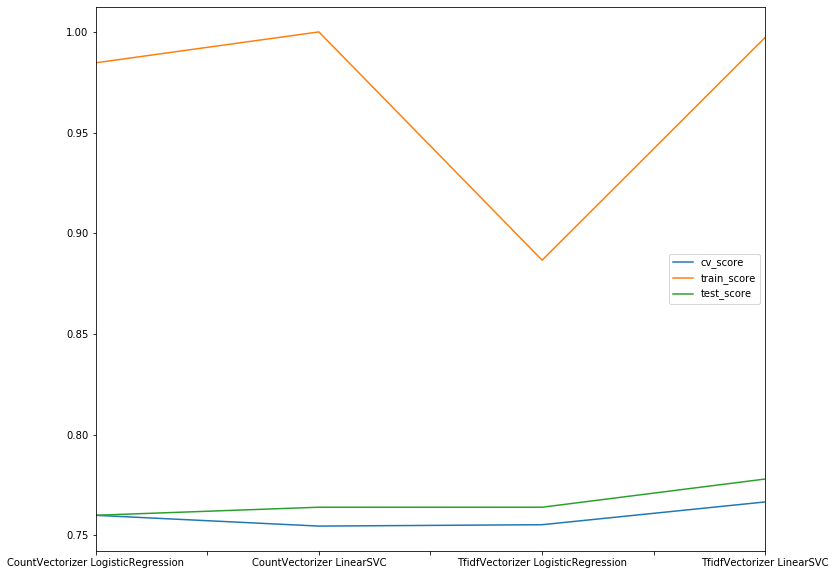

In [72]:
scores.plot(figsize=(12, 10))

Как видим все модели переобучаются, т.к. train score близок к единице, это значит что наши модели сложные, или нам не хватает данных.
- чтобы упростить модель, нужно трогать гиппер параметры векторайзера и классификатора
- чтобы получить данные, их нужно откуда то взять **¯\_(ツ)_/¯**

---
---

Попробуем обучить наши дополнительно на данных с nltk, кроме movie_reviews я там не нашел подходящих текстов

In [76]:
X, y = get_X_y()

In [87]:
movie = pd.DataFrame({0: X, 1: y})

In [88]:
movie

,0,1
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard ' s quick movie review damn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' first...",0
4,synopsis : a mentally unstable man undergoing ...,0
...,...,...
1995,wow ! what a movie . it ' s everything a movie...,1
1996,"richard gere can be a commanding actor , but h...",1
1997,"glory -- starring matthew broderick , denzel w...",1
1998,steven spielberg ' s second epic film on world...,1


In [90]:
new_data = pd.concat([data, movie])

In [92]:
new_data.shape

(4000, 2)

In [93]:
#cv сам перемешивает данные

X_train, X_test, y_train, y_test = train_test_split(new_data[0], new_data[1], test_size=0.33)

Делаем всё тоже самое

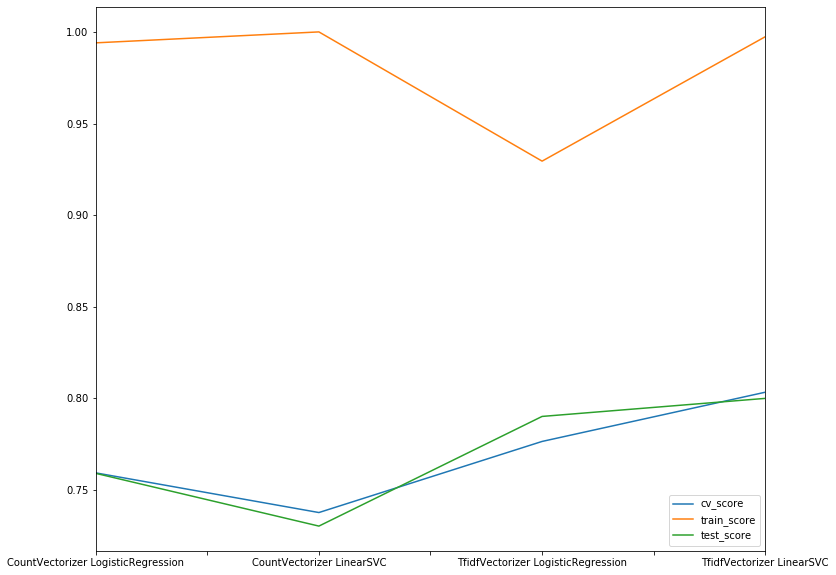

In [97]:
columns = ["cv_score", "train_score", "test_score"]
result = []
names = []

for vec in (CountVectorizer, TfidfVectorizer):
    for clf in (LogisticRegression, LinearSVC):
        
        names.append(vec.__name__  + " " +  clf.__name__)
        pipeline = create_pipeline(vec(), clf())

        cv_score = cross_val_score(pipeline, X_train, y_train, cv=5).mean() 
        pipeline.fit(X_train, y_train)
        train_score = accuracy_score(y_train, pipeline.predict(X_train))
        test_score = accuracy_score(y_test, pipeline.predict(X_test))
        
        result.append([cv_score, train_score, test_score])

scores = pd.DataFrame(result, columns=columns, index=names)
scores.plot(figsize=(12, 10))

1. Переобучение всё еще присутсвует

2. Качество повысилось, но на практике это может не помочь, т.к. наша модель обучается еще и на фильмах, а задание про обзор продуктов. Тем не менее у обзоров чего-либо есть общие моменты.

---
---

Лучше всего себя показала связка TfidfVectorizer и LinearSVC, будем её использовать в итоговом решении, пока без настройки гиппер параметров. Попробуем залить на кагл решение без доп данных и с ними

In [101]:
test_data = pd.read_csv("../data/products_sentiment_test.tsv", sep="\t")
test_data.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [105]:
data_id = test_data["Id"]
data_id[:5]

0    0
1    1
2    2
3    3
4    4
Name: Id, dtype: int64

In [106]:
# решение без дополнительных данных
pipeline = create_pipeline(TfidfVectorizer(), LinearSVC())
pipeline.fit(data[0], data[1])
result_a = pipeline.predict(test_data["text"])
result_a[:5]
                           

array([1, 0, 1, 1, 0], dtype=int64)

In [107]:
data_id.shape, result_a.shape

((500,), (500,))

In [108]:
# записываем данные в файл
pd.DataFrame({'Id' : data_id, 'y' : result_a}).to_csv('submission_a.csv', index=False)

<img src="../data/some_score_a_1.png">


## <center>  В итоге получили точность в 0.79, baseline побит, задача решена

___
___



Попробуем на модели с дообученными данными

In [109]:
pipeline = create_pipeline(TfidfVectorizer(), LinearSVC())
pipeline.fit(new_data[0], new_data[1])
result_b = pipeline.predict(test_data["text"])
result_b[:5]

array([1, 0, 1, 1, 0], dtype=int64)

In [113]:
(result_a != result_b).sum()

45

In [115]:
pd.DataFrame({'Id' : data_id, 'y' : result_b}).to_csv('submission_b.csv', index=False)

<img src="../data/some_score_b_1.png">

Точность получилась хуже, получается если и докидывать данные то релевантные по теме, что в общем то ожидаемо.

Получается модель можно улучшить следующим образом
- упростить модель и избавиться от переобучения
- найти релевантные данные

давайте попробуем упростить модель

In [122]:
vec = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=0.1)
clf = LinearSVC(penalty='l1', fit_intercept=False, C=0.7, dual=False)
pipeline = create_pipeline(vec, clf)
pipeline.fit(data[0], data[1])
result_c = pipeline.predict(test_data["text"])
pd.DataFrame({'Id' : data_id, 'y' : result_c}).to_csv('submission_c.csv', index=False)

Результат данной попытки 0.63333 **¯\_(ツ)_/¯**

Еще один вариант - предобработка данных, но baseline побит с самого начала, поэтому хватит

<img src="Yekimchuk_result.png">

Скриншот с нынешним местом, попробовал решение которое описано на кагле